# Subcellular Localization Analysis

**Author**: Clarence Mah<br>
**Last Updated**: 6/5/2022

Here we will analyze cultured 3T3 mouse embryonic stem cells in which 10k genes are spatially profiled with seqFISH+ in [Eng. et al 2019](https://doi.org/10.1038/s41586-019-1049-y). The dataset here consists of 211 cells, each with cell/nuclear segmentation masks and 2D transcript coordinates. Here we showcase how Bento enables subcellular analysis of spatial transcriptomics data.

<img src="../_static/tutorial_img/bento_workflow.png" alt="Bento Workflow" width="1200">

## Load Libraries

We will be using `bento` for subcellular spatial analysis and visualization, along with `scanpy` for handling single-cell gene expression data.

<div class="alert alert-info">

Note

Similar to other tools in the python single-cell omics ecosystem, `bento` adopts an API organized under a set of modules including:

- `bento.io`: reading and writing data stored in the `AnnData` format, customized to hold molecular coordinates and segmentation masks

- `bento.pp`: preprocessing data

- `bento.tl`: subcellular spatial analyses

- `bento.pl`: visualizing subcellular-resolution spatial data, localization pattern statistics, and more

</div>

In [1]:
import bento
import scanpy as sc

## Load Data

Let's grab the `seqFISH+` dataset. This will download the dataset into `data_home`, which by default is set to `~/bento-data`.

The loaded object is an `AnnData` object, structured similarly to single-cell omics anlayses, where observations are cells, features are genes, and the main matrix is an expression count matrix. To store subcellular information, `bento` stores:
- Molecular coordinates: formatted as `DataFrames` in `uns['points']`
- Segmentation masks: formatted as `geopandas.GeoSeries` in `obs` denoted as `{}_shape`. In this case, we have cell and nuclear segmentations stored in `cell_shape` and `nucleus_shape` respectively.

In [2]:
adata = bento.datasets.load_dataset("seqfish_raw")
adata

AnnData object with n_obs × n_vars = 211 × 9506
    obs: 'cell_shape', 'nucleus_shape', 'batch'
    uns: 'points'
    layers: 'spliced', 'unspliced'

What does our data look like? For starters, we can visualize molecules as their spatial density in a single field of view. You may notice not all some cells are missing nuclear masks for one reason or another. We can handle this with [Quality Control](#Quality-Control) metrics in the next section.

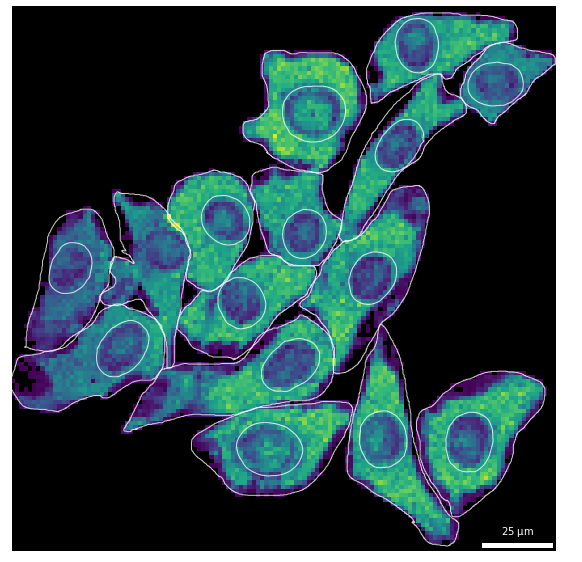

In [3]:
bento.pl.cellplot(adata)

## Quality Control

Calculate and plot QC metrics including those used for single-cell RNA-seq analysis. We can use cell area and perimeter to identify outlier cells that are extremely large or small. Then we can filter those out from our data. For the purpose of this analysis, these outlier have already been filtered. We will instead identify cells without annotated nuclei and remove those.

In [4]:
sc.pp.calculate_qc_metrics(adata, inplace=True, percent_top=None)
bento.tl.cell_area(adata)
bento.tl.cell_density(adata)

AnnData object modified:
    obs:
        + cell_area
AnnData object modified:
    obs:
        + cell_density


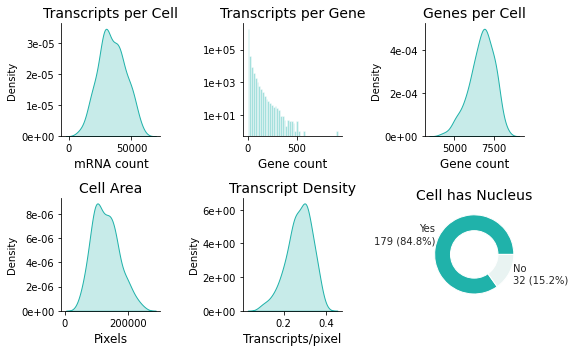

In [5]:
bento.pl.qc_metrics(adata)

Filter out cells without a nucleus.

In [6]:
adata = adata[adata.obs["nucleus_shape"] != None]
bento.pp.set_points(adata)

Trying to set attribute `.uns` of view, copying.


We will also filter genes and only include genes for which at least 10 molecules are detected in at least one cell. This helps reduce data sparsity for our downstream analysis, resulting in 3726 genes.

In [7]:
valid_genes = adata.var_names[(adata.to_df() >= 10).sum() >= 1]

adata = adata[:,valid_genes]
bento.pp.set_points(adata)

Trying to set attribute `.uns` of view, copying.


In [8]:
adata

AnnData object with n_obs × n_vars = 179 × 3726
    obs: 'cell_shape', 'nucleus_shape', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'cell_area', 'cell_density'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'points'
    layers: 'spliced', 'unspliced'

In [9]:
bento.pp.get_points(adata).shape

(4531290, 6)

## Subcellular Localization Patterns

Now that we have a sense of our data, we will apply a pattern classifier to predict and annotate subcellular localization patterns for our dataset. A single "sample" refers to the set of points corresponding for a given gene in a single cell.

<img src="../_static/tutorial_img/bento_pattern_annotation.png" alt="Bento Pattern Annotation Workflow" width="800">

### Calculate spatial features

These features are used by the classifier to predict patterns for each sample. The entire dataset takes ~8 hours to process, therefore we have provided precomputed features to proceed with the analysis.

<div class="alert alert-info">

Note

Why does it take so long? Unlike single-cell analysis which uses expression counts, we are computing spatial relationships considering every molecule! In this dataset there are >4 million molecules and multiple high-resolution polygons for every cell.

</div>

For the curious, all the gory details of each feature are described here.
<details>
    <summary>
        Feature Table (Toggle Me)
    </summary>
    
| **Categories** | **Features** |
| -------------- | ------------ |
| Distance       | **Cell inner proximity**: The average distance between all points within the cell to the cell boundary normalized by cell radius. Values closer to 0 denote farther from the cell boundary, values closer to 1 denote closer to the cell boundary.<br>**Nucleus inner proximity**: The average distance between all points within the nucleus to the nucleus boundary normalized by cell radius. Values closer to 0 denote farther from the nucleus boundary, values closer to 1 denote closer to the nucleus boundary.<br>**Nucleus outer proximity**: The average distance between all points within the cell and outside the nucleus to the nucleus boundary normalized by cell radius. Values closer to 0 denote farther from the nucleus boundary, values closer to 1 denote closer to the nucleus boundary. |
| Symmetry       | **Cell inner asymmetry**: The offset between the centroid of all points within the cell to the centroid of the cell boundary, normalized by cell radius. Values closer to 0 denote symmetry, values closer to 1 denote asymmetry.<br>**Nucleus inner asymmetry**: The offset between the centroid of all points within the nucleus to the centroid of the nucleus boundary, normalized by cell radius. Values closer to 0 denote symmetry, values closer to 1 denote asymmetry.<br>**Nucleus outer asymmetry**: The offset between the centroid of all points within the cell and outside the nucleus to the centroid of the nucleus boundary, normalized by cell radius. Values closer to 0 denote symmetry, values closer to 1 denote asymmetry.                                                                |
| Dispersion     | **Point dispersion**: The second moment of all points in a cell relative to the centroid of the total RNA signal. This value is normalized by the second moment of a uniform distribution within the cell boundary.<br>**Nucleus dispersion**: The second moment of all points in a cell relative to the centroid of the nucleus boundary. This value is normalized by the second moment of a uniform distribution within the cell boundary.                                                                                                                                                                                                                                                                                                                                                                    |
| Density        | **L-function max**: The max value of the L-function evaluated at r=[1,d], where d is half the cell’s maximum diameter.<br>**L-function max gradient**: The max value of the gradient of the above L-function.<br>**L-function min gradient**: The min value of the gradient of the above L-function.<br>**L monotony**: The correlation of the L-function and r=[1,d].<br>**L-function at d/2**: The value of the L-function evaluated at ¼ of the maximum cell diameter.   *The L-function measures spatial clustering of a point pattern over an area of interest.*                                                                                                                                   
</details>
<br>

In [10]:
# Load dataset with precomputed features
adata = bento.datasets.load_dataset('seqfish')

### Predict Subcellular Patterns

Predict the subcellular pattern for every sample (by default, only samples with count >= 5). The five subcellular patterns we can predict are:
- **cell edge**: near the cell membrane
- **cytoplasmic**: mostly outside the nucleus in the cytoplasm
- **nuclear**: most in the nucleus
- **nuclear edge**: near the nuclear membrane, either
- **none**: none of the above patterns, more or less randomly distributed

<img src="../_static/tutorial_img/subcellular_patterns.png" alt="Subcellular Patterns" width="250">

In [11]:
bento.tl.lp(adata)

  0%|          | 0/5 [00:00<?, ?it/s]

We can view the observed pattern frequencies to get a rough idea of how transcripts are localizing.

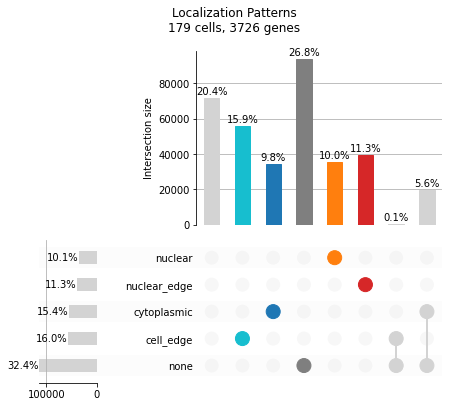

In [12]:
bento.pl.lp_dist(adata, percentage=True)

We can also visualize the localization of each gene where the point position denotes the balance between subcellular localization pattern frequencies. The color denotes the gene's most frequent pattern. Interestingly, we see a wide range of variability in localization. A large number of genes are pulled towards none while nuclear enriched genes show strong bias and a high fraction of cells.

No handles with labels found to put in legend.


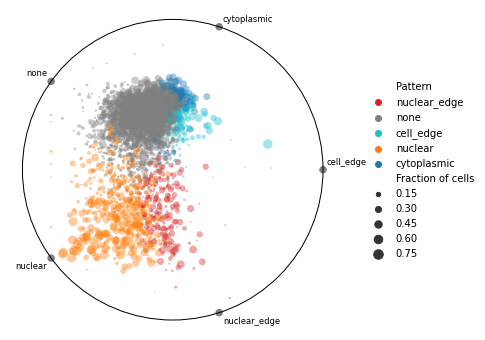

In [13]:
bento.pl.lp_genes(adata, alpha=0.4)

## Localization signatures: quantifying cell to cell variability

Just as gene expression varies from cell to cell, gene localization is dynamic even with a single cell type. Here we will use a method called tensor decomposition to explore this variation. Tensor decomposition breaks down a tensor, or multi-dimensional matrix, into a set of factors. This is similar to how performing PCA on gene expression produces a set of principal components. In this case, we will apply tensor decomposition to a 3-dimensional tensor; the dimensions correspond to patterns, cells, and genes. 

<img src="../_static/tutorial_img/tensor_decomposition.png" alt="Tensor Decomposition" width="800">

Here is the shape of our dataset tensor.

In [14]:
adata.uns['tensor'].shape

(5, 179, 3726)

First we will determine the number of factors used to represent our dataset. To do so, we will perform tensor decomposition for a range of values (default [1-5], three times each) and calculate the reconstruction loss with the original tensor at each value. Reconstruction accuracy across range of decomposition ranks (1 is perfect, 0 is noise). The best rank is highlighted in red as determined by the elbow method.

<div class="alert alert-info">

Note

Estimating rank can be difficult; here we are using a heuristic and therefore may not generalize perfectly to a different dataset. Try increasing the `upper_rank` if the error does not flatten, or increasing `runs` if the confidence interval is too wide.

</div>

Device: cpu


  0%|          | 0/5 [00:00<?, ?it/s]

The rank at the elbow is: 3


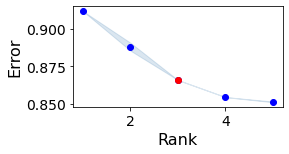

In [15]:
bento.tl.select_tensor_rank(adata, bento.PATTERN_NAMES)

Perform tensor decomposition at a chosen rank (e.g. best rank above).

In [16]:
bento.tl.lp_signatures(adata, 3)

Device: cpu


Each factor is described by 3 vectors, the pattern vector (it's mislabeled as layers TODO fix), cell vector, and gene vector. Genes and cells are ordered by clustering (hierarchical clustering) for visual clarity. Higher loading values, which indicate stronger association with the factor, are denoted by darker colors.

**Pattern color key:**

<img src="../_static/tutorial_img/subcellular_patterns.png" alt="Subcellular Patterns" width="250">

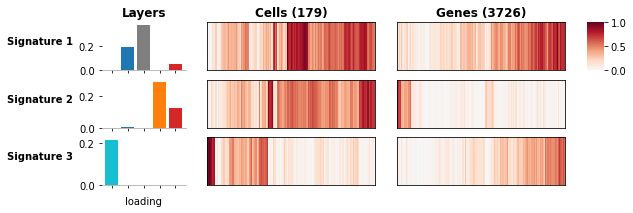

In [17]:
bento.pl.lp_signatures(adata)

Let's plot the top 5 cells and top 5 genes associated with each signature. As expected, the signatures generally agree with the pattern loadings above. The first signature’s pattern loading is dominated by “none” and “cytoplasmic”, while signature 2 is a combination of “nuclear” and “nuclear edge” and signature 3 is primarily “cell edge”. 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

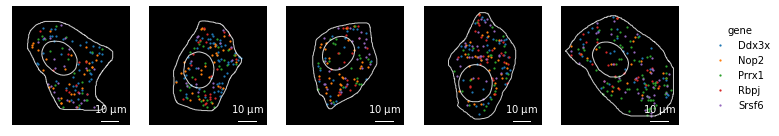

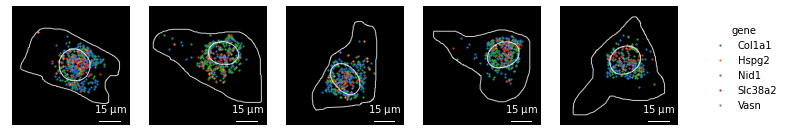

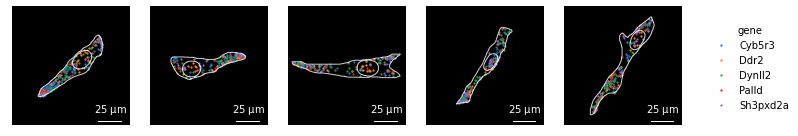

In [18]:
bento.pl.sig_samples(adata)

We find these signatures recapitulate patterns found in the original seqFISH+ study, in which three major clusters of spatially co-occurring genes were observed and manually annotated as protrusion, nuclear/perinuclear, and cytoplasmic. This demonstrates the ability of tensor decomposition to extract meaningful biological structure from localization patterns in a data-driven manner.

<div class="alert alert-info">

Note 

We recommend characterizing the gene and cell loadings of each signature to aid in interpretation. Refer to our paper for more details regarding these localization signatures! If you are analyzing your own dataset, we encourage reaching out the authors directly if you have any questions about your analysis or feature requests for `bento`!

</div>